In [1]:
push!(LOAD_PATH,"C:/JMB/DINEOF.jl/src","."); using DINEOF
using PyPlot
using LinearAlgebra
using Arpack
using Random
using Statistics

┌ Info: Recompiling stale cache file C:\Users\jmbeckers\.julia\compiled\v1.2\DINEOF.ji for DINEOF [top-level]
└ @ Base loading.jl:1240


In [2]:
?DINEOF_svd

search: DINEOF_svd DINEOF_svds! DINEOF_fuse! DINEOF_musquare DINEOF_cvmask



```
U,S,V,ncon,nit=DINEOF_svd(X,nele,svdmeth="svd",svdtol=0.00001;filter="None",filterintensity=1.0,filterrepetitions=1)
```

# Lowest level interface to SVD decomposition

# Input:

  * `X`: a two-dimensional array of size MxN with N<=M and no missing values.
  * `nele`: the number of singular vectors and values asked for (<=N)
  * `svdmeth`: if `svd` uses SVD decomposition, if `eig` uses eigenvalue approach on X'X. Results should be identical but CPU demand could be different
  * `svdtol`: tolerance for convergence criteria during SVD decomposition
  * `filter`: Filter to be applied to second dimension. For the moment implementation of 

    "None" : no filter applied

    "vpmf" : Very poor mans filter: applies a postprocessing filter to V and adapts U and S to get an orthonormal base. It is NOT the best approximation of X or the filtered X

    "pmf" : poor mans filter: applies a preprocessing filter on X (or X'X which mathematically is identical). USV' is the best approximation to the filtered X

For the two filters a diffusion-like filter is applied. filterintensity=1 is the strongest filter that should be used and amounts to a 0.25,0.5,0.25 filter stencil. filterrepetitions defines how many diffusion-like steps are used (so how wide the filter stencil becomes). Presently not variable distance between images is implemented.

# Output:

  * `U,S,V`: the SVD decomposition such that in the infiltered version USV' is the best approximation of X with nele singular vectors.
  * `ncon` : number of converged singular values, should be equal to nele
  * `nit` : number of iterations needed to find the singular values (can be used to adapt tolerance svdtol)


Normally the user will not call that function direction but in case he wants, here it how it works

In [3]:
Random.seed!(123)

MersenneTwister(UInt32[0x0000007b], Random.DSFMT.DSFMT_state(Int32[1464307935, 1073116007, 222134151, 1073120226, -290652630, 1072956456, -580276323, 1073476387, 1332671753, 1073438661  …  138346874, 1073030449, 1049893279, 1073166535, -1999907543, 1597138926, -775229811, 32947490, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x0000000000000

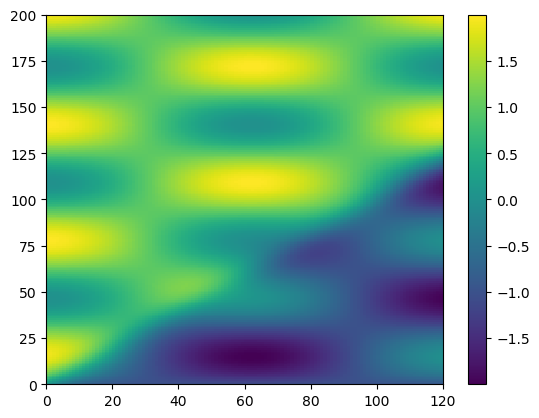

(PyObject <matplotlib.collections.PolyCollection object at 0x000000003801C6D8>, PyObject <matplotlib.colorbar.Colorbar object at 0x00000000398BC4E0>)

In [4]:
NX=200
NY=120
X=zeros(Float64,NX,NY)
      for j=1:NY
            for i=1:NX
        X[i,j]=sin(i/10)*cos(j/20)+tanh((i-j)/10)
            end
        end

# warm up
WW=DINEOF_svd(X,3)
WW=DINEOF_svd(X,3,"eig")
pcolor(X),colorbar()

Defaults only

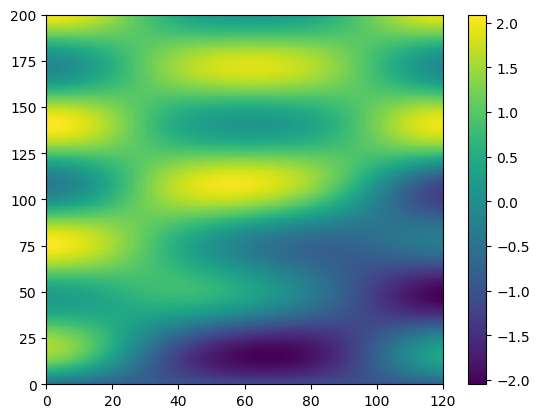

  0.012508 seconds (3.46 k allocations: 241.284 KiB)


(PyObject <matplotlib.collections.PolyCollection object at 0x0000000039AAE828>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000003A98C5F8>)

In [5]:
@time U,S,V,ncon,nit=DINEOF_svd(X,3)
pcolor(U*diagm(S)*V'),colorbar()

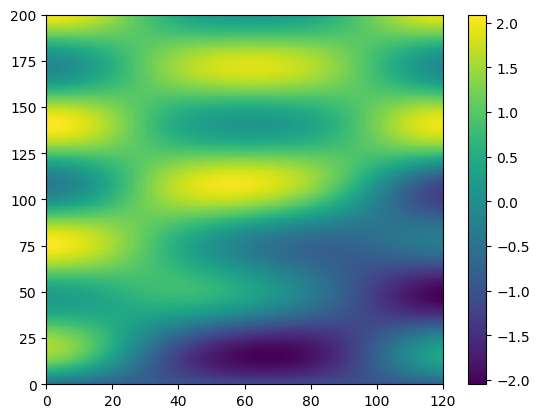

  0.013590 seconds (3.41 k allocations: 348.101 KiB)


(PyObject <matplotlib.collections.PolyCollection object at 0x000000003A9CF320>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000003C7FD0F0>)

In [6]:
@time U,S,V,ncon,nit=DINEOF_svd(X,3,"eig")
pcolor(U*diagm(S)*V'),colorbar()

With some noise

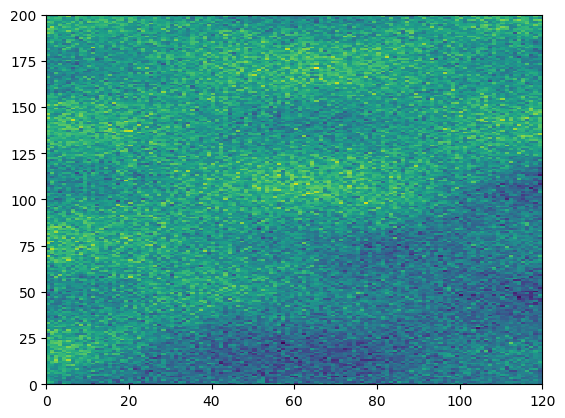

PyObject <matplotlib.collections.PolyCollection object at 0x000000003C9B0898>

In [7]:
X=X+randn(size(X))
pcolor(X)

Normal

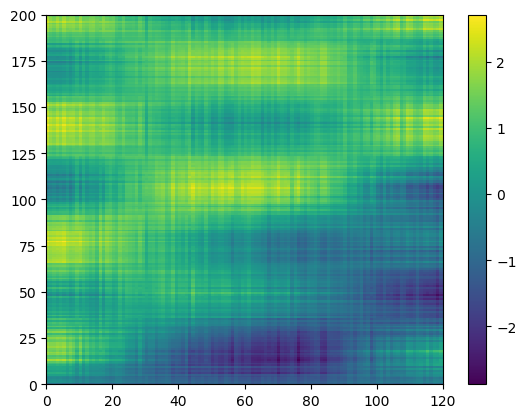

  0.002439 seconds (183 allocations: 52.375 KiB)


(PyObject <matplotlib.collections.PolyCollection object at 0x000000003D7FAFD0>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000003F4A7C50>)

In [8]:
@time U,S,V,ncon,nit=DINEOF_svd(X,3)
pcolor(U*diagm(S)*V'),colorbar()

Poor mans filter on X

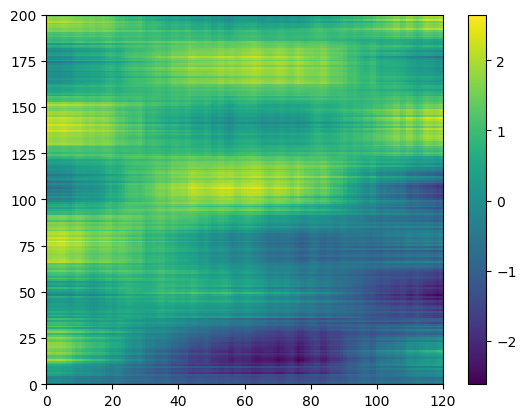

  0.356995 seconds (581.88 k allocations: 31.098 MiB, 4.59% gc time)


(PyObject <matplotlib.collections.PolyCollection object at 0x000000003F6581D0>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000004032EF60>)

In [9]:
@time U,S,V,ncon,nit=DINEOF_svd(X,3;filter="pmf")
pcolor(U*diagm(S)*V'),colorbar()

Poor mans filter with more iterations

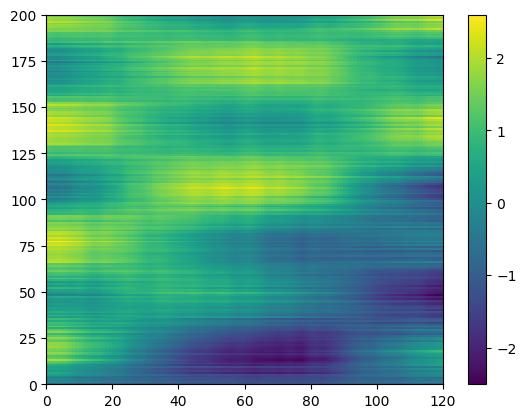

  0.045742 seconds (15.63 k allocations: 5.895 MiB)


(PyObject <matplotlib.collections.PolyCollection object at 0x0000000040360780>, PyObject <matplotlib.colorbar.Colorbar object at 0x000000004218F4E0>)

In [10]:
@time U,S,V,ncon,nit=DINEOF_svd(X,3;filter="pmf",filterrepetitions=5)
pcolor(U*diagm(S)*V'),colorbar()

Poor mans filter with iterations but filter on B

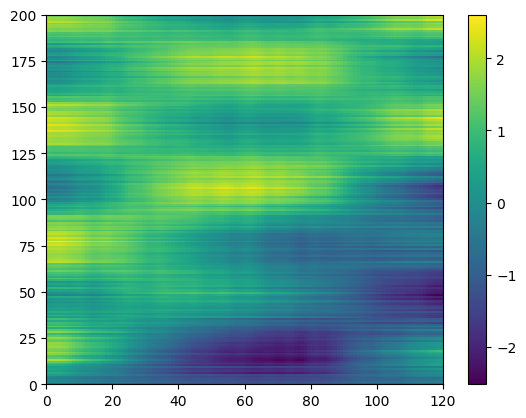

  1.009859 seconds (1.49 M allocations: 81.137 MiB, 2.55% gc time)


(PyObject <matplotlib.collections.PolyCollection object at 0x00000000421B6A20>, PyObject <matplotlib.colorbar.Colorbar object at 0x00000000430157F0>)

In [11]:
@time U,S,V,ncon,nit=DINEOF_svd(X,3,"eig";filter="pmf",filterrepetitions=5)
pcolor(U*diagm(S)*V'),colorbar()

Very poor mans filter: filter on V

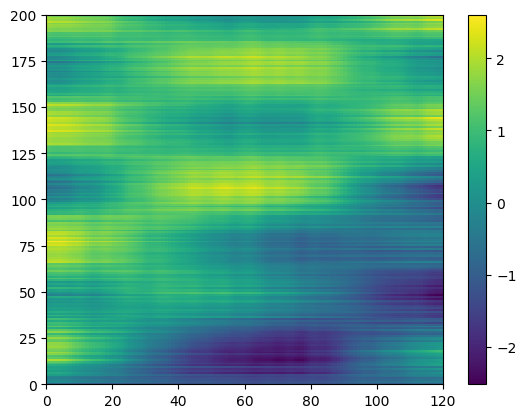

  0.214802 seconds (398.31 k allocations: 20.716 MiB, 3.11% gc time)


(PyObject <matplotlib.collections.PolyCollection object at 0x000000004303CE48>, PyObject <matplotlib.colorbar.Colorbar object at 0x0000000044E9BBA8>)

In [12]:
@time U,S,V,ncon,nit=DINEOF_svd(X,3;filter="vpmf",filterrepetitions=5)
pcolor(U*diagm(S)*V'),colorbar()

Using less modes does not eliminate the noise totally

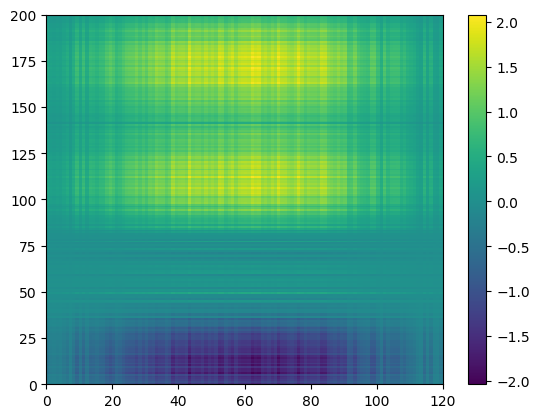

  0.002055 seconds (189 allocations: 42.344 KiB)


(PyObject <matplotlib.collections.PolyCollection object at 0x0000000045050438>, PyObject <matplotlib.colorbar.Colorbar object at 0x0000000045D2E208>)

In [13]:
@time U,S,V,ncon,nit=DINEOF_svd(X,1;filter="None")
pcolor(U*diagm(S)*V'),colorbar()